In [1]:
#CHESAPEAKE BAY, MD

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pdb
from IPython.display import display
import os
import glob

In [2]:
import ee
import geemap

ee.Initialize()

In [3]:
#Station coordinates (FLATS around stations?)

stazioni = pd.read_csv('C:/Users/arj26323/Documents/Data/NERR data/All_stations2.csv')

# print(stazioni['Station Code'].unique())

stazioni = stazioni[stazioni['Station Code'].str.contains('nut')]

stazioni.rename(columns={"Latitude ": "Latitude", " Longitude": "Longitude"}, inplace= True)

dfs = stazioni[['Station Code', 'Station Name', 'Latitude', 'Longitude']]

dfx = dfs[dfs['Station Code']=='cbmrrnut  '] #two spaces put in after each code for some stupid fucking reason

dfx

,Station Code,Station Name,Latitude,Longitude
42,cbmrrnut,Railroad,38.7813,-76.7137


In [4]:
px = ee.Geometry.Point([dfx.iloc[0,3], dfx.iloc[0,2]])


In [5]:
Map = geemap.Map(center=[38.7813,-76.7137], zoom=16)

# Map

In [6]:
##Function to cloud mask from the pixel_qa band of Landsat 5/8 SR data.
def maskL5sr(image):
    qaMask = image.select('QA_PIXEL').bitwiseAnd(int('11111', 2)).eq(0)
    saturationMask = image.select('QA_RADSAT').eq(0)
    # Apply the scaling factors to the appropriate bands.
    opticalBands = image.select('SR_B.').multiply(0.0000275).add(-0.2)
    thermalBands = image.select('ST_B.*').multiply(0.00341802).add(149.0)
    # Replace the original bands with the scaled ones and apply the masks.
    return image.addBands(opticalBands, None, True) \
    .addBands(thermalBands, None, True) \
    .updateMask(qaMask) \
    .updateMask(saturationMask)

def addFLATSL7(image):
    flats = ee.Image(0).expression(
        '1/(1+2.718281828459045**-(1.51 + 12.5*(RED-SWIR)/(RED+SWIR) - 41.2*(NIR-RED)/(NIR+6*RED-7.5*BLUE+1)))', {
            'SWIR': image.select('SR_B5'),
            'NIR': image.select('SR_B4'),
            'RED': image.select('SR_B3'),
            'BLUE': image.select('SR_B1')
        })
    
    return image.addBands(flats.rename('flats'))

def addFLATSL5(image):
    flats = ee.Image(0).expression(
        '1/(1+2.718281828459045**-(1.51 + 12.5*(0.972*(RED-SWIR)/(RED+SWIR)-0.008) - 41.2*(0.991*(NIR-RED)/(NIR+6*RED-7.5*BLUE+1)-0.0014)))', {
            'SWIR': image.select('SR_B5'),
            'NIR': image.select('SR_B4'),
            'RED': image.select('SR_B3'),
            'BLUE': image.select('SR_B1')
        })
    
    return image.addBands(flats.rename('flats'))


def addFLATSL8(image):
    flats = ee.Image(0).expression(
        '1/(1+2.718281828459045**-(1.51 + 12.5*(0.841*(RED-SWIR)/(RED+SWIR) - 0.019) - 41.2*(0.771*(NIR-RED)/(NIR+6*RED-7.5*BLUE+1) + 0.011)))', {
            'SWIR': image.select('SR_B6'),
            'NIR': image.select('SR_B5'),
            'RED': image.select('SR_B4'),
            'BLUE': image.select('SR_B2')
        })
    
    return image.addBands(flats.rename('flats'))

def addFLATSL9(image):
    flats = ee.Image(0).expression(
        '1/(1+2.718281828459045**-(1.51 + 12.5*(1.225*(RED-SWIR)/(RED+SWIR) + 0.096) - 41.2*(1.038* (NIR-RED)/(NIR+6*RED-7.5*BLUE+1) - 0.004)))', {
            'SWIR': image.select('SR_B6'),
            'NIR': image.select('SR_B5'),
            'RED': image.select('SR_B4'),
            'BLUE': image.select('SR_B2')
        })
    
    return image.addBands(flats.rename('flats'))

def add_date_band(image):
    # Get the acquisition date
    date = ee.Date(image.get('system:time_start'))
    
    # Convert the date to milliseconds since Unix epoch
    date_millis = date.millis()
    
    # Create an image with a single band representing the acquisition date
    date_image = ee.Image.constant(date_millis).int64().rename('acquisition_date')
    
    # Add the date image as a band to the original image
    return image.addBands(date_image)

gce_lter = geemap.shp_to_ee('F:/Wetlands shapefiles/GCE domain/GCE_LTER_boundary.shp')

#Loading gee datasets
l8_col = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2') \
    .filter(ee.Filter.calendarRange(1998, 2023,'year')) \
    .filterBounds(px.buffer(10000)) \
    .map(maskL5sr).map(addFLATSL8).map(add_date_band)

l7_col = ee.ImageCollection('LANDSAT/LE07/C02/T1_L2') \
    .filter(ee.Filter.calendarRange(1984, 2023,'year')) \
    .filterBounds(px.buffer(10000))\
    .map(maskL5sr).map(addFLATSL7).map(add_date_band)

l5_col = ee.ImageCollection('LANDSAT/LT05/C02/T1_L2') \
    .filter(ee.Filter.calendarRange(1984, 2023,'year')) \
    .filterBounds(px.buffer(10000))\
    .map(maskL5sr).map(addFLATSL5).map(add_date_band)

l9_col = ee.ImageCollection("LANDSAT/LC09/C02/T1_L2") \
    .filter(ee.Filter.calendarRange(1998, 2023,'year')) \
    .filterBounds(px.buffer(10000))\
    .map(maskL5sr).map(addFLATSL9).map(add_date_band)

In [7]:
area_nut = geemap.shp_to_ee('F:/Wetlands shapefiles/VA_shapefile_wetlands/md_wetland_nut.shp')

Map.addLayer(l8_col.first(), {'bands': ['SR_B5',  'SR_B4',  'SR_B3'], 'min': 0, 'max': 0.2}, 'Landsat 9')

Map.addLayer(area_nut, {}, 'NERR area')
Map.addLayer(px, {}, 'NERR station')

# Map

In [8]:
ultra_col = l5_col.merge(l7_col).merge(l8_col).merge(l9_col)

# ultra = ultra_col.filter(ee.Filter.calendarRange(1984, 2023,'year')).filterBounds(flux_ga)
ultra = ultra_col.filter(ee.Filter.calendarRange(1984, 2024,'year')).map(lambda image: image.clip(area_nut)) \
    .filter(ee.Filter.lte('CLOUD_COVER_LAND', 50))

In [9]:
def area_extract(image):
    
    feature = ee.Image(image).reduceRegions(
        collection = area_nut,
        reducer = ee.Reducer.mean(),
        scale=30
    )
    
    return feature

#reduceRegion doesn't work (geometry instead of collection) - why? maybe loop below is the issue

In [10]:
im_list = ultra.toList(ultra.size())

In [15]:
#Extraction - takes a long time!
feature_list = ultra.map(area_extract).flatten().toList(ultra.size())
values_list = []

# Loop through the feature list and extract values
for i in range(feature_list.size().getInfo()):
    feature = ee.Feature(feature_list.get(i))
    properties = feature.toDictionary()
    values_list.append(properties.getInfo())

# Convert the list of dictionaries to a pandas DataFrame
timeseries_df = pd.DataFrame(values_list)

# Print the DataFrame
print(timeseries_df)

     Shape_Area  Shape_Leng  acquisition_date      QA_PIXEL  QA_RADSAT  \
0    9236.88081  525.079752      461862612145           NaN        NaN   
1    9236.88081  525.079752      463245020995           NaN        NaN   
2    9236.88081  525.079752      812990467402           NaN        NaN   
3    9236.88081  525.079752      814372814729           NaN        NaN   
4    9236.88081  525.079752      947085320243           NaN        NaN   
..          ...         ...               ...           ...        ...   
790  9236.88081  525.079752     1694879191904  21824.000000        0.0   
791  9236.88081  525.079752     1696261591676  21827.578705        0.0   
792  9236.88081  525.079752     1697644001938  21832.333972        0.0   
793  9236.88081  525.079752     1699026394403  21845.815396        0.0   
794  9236.88081  525.079752     1700408801132  21847.923401        0.0   

     SR_ATMOS_OPACITY     SR_B1     SR_B2     SR_B3     SR_B4  ...  ST_DRAD  \
0                 NaN       NaN 

In [12]:
import os 
out_dir = os.path.expanduser('C:/Users/arj26323/Documents/Data/NERR data/')
out_csv = os.path.join(out_dir, 'md_timeseries_area.csv')
# timeseries_df.to_csv(out_csv, index = False)

In [16]:
timeseries_df = pd.read_csv('C:/Users/arj26323/Documents/Data/NERR data/md_timeseries_area.csv')

timeseries_df['Date'] = pd.to_datetime(timeseries_df['acquisition_date'], unit = 'ms')
timeseries_df['DOY'] = timeseries_df['Date'].dt.strftime('%Y-%m-%d')
timeseries_df['DOY'] = pd.to_datetime(timeseries_df['DOY'])

timeseries_df

,Shape_Area,Shape_Leng,acquisition_date,QA_PIXEL,QA_RADSAT,SR_ATMOS_OPACITY,SR_B1,SR_B2,SR_B3,SR_B4,...,ST_EMSD,ST_QA,ST_TRAD,ST_URAD,flats,SR_B6,SR_QA_AEROSOL,ST_B10,Date,DOY
0,9236.88081,525.079752,461862612145,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1984-08-20 15:10:12.145,1984-08-20
1,9236.88081,525.079752,463245020995,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1984-09-05 15:10:20.995,1984-09-05
2,9236.88081,525.079752,812990467402,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1995-10-06 14:41:07.402,1995-10-06
3,9236.88081,525.079752,814372814729,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1995-10-22 14:40:14.729,1995-10-22
4,9236.88081,525.079752,947085320243,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000-01-05 15:15:20.243,2000-01-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
790,9236.88081,525.079752,1694879191904,21824.000000,0.0,NaN,0.019384,0.024668,0.042297,0.044323,...,185.470318,269.403677,8830.821524,1330.0000,0.036825,0.133528,90.749138,297.361581,2023-09-16 15:46:31.904,2023-09-16
791,9236.88081,525.079752,1696261591676,21827.578705,0.0,NaN,0.020205,0.026759,0.042467,0.047504,...,185.470318,262.034470,8657.103026,2401.7545,0.049345,0.142668,92.513979,297.712115,2023-10-02 15:46:31.676,2023-10-02
792,9236.88081,525.079752,1697644001938,21832.333972,0.0,NaN,0.027210,0.033048,0.045923,0.057354,...,185.470318,349.308694,7919.102260,1012.0000,0.078235,0.165484,90.749138,290.846495,2023-10-18 15:46:41.938,2023-10-18
793,9236.88081,525.079752,1699026394403,21845.815396,0.0,NaN,0.026728,0.032837,0.045133,0.057628,...,185.470318,236.307162,7433.090387,452.0000,0.122543,0.158699,90.749138,286.063517,2023-11-03 15:46:34.403,2023-11-03


<Axes: xlabel='Date', ylabel='flats'>

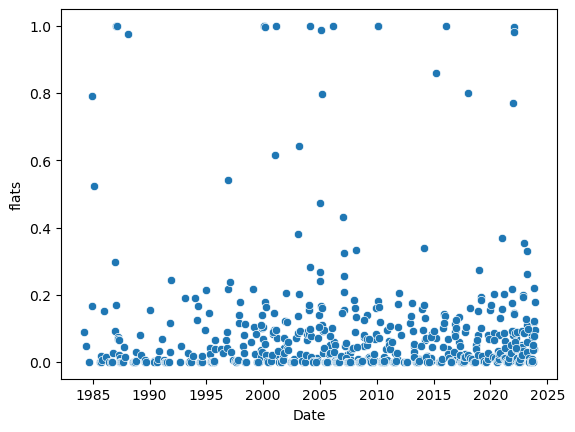

In [17]:
import seaborn as sns
sns.scatterplot(data = timeseries_df, x = 'Date', y = 'flats')

In [12]:
##LANDSAT ACQUISITION TIME!!! FOR TIDE/TIME MERGING

In [18]:
#Tides -- VA (is this close enough to where NERR station is? check tide gauge location)

path = r'C:/Users/arj26323/Documents/Data/Tide data/MD_tides_8577330_Solomons_Island_MD' 
all_files = glob.glob(path + "/*.csv")

li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

df = pd.concat(li, axis=0, ignore_index=True)

df2 = df.copy()
df2['Time (GMT)'] = pd.to_datetime(df2['Time (GMT)'])
df2['DOY'] = pd.to_datetime(df2['Date'])

time_mask = (df2['Time (GMT)'].dt.hour == 16)
va_time = df2[time_mask]

va_time['Verified (m)'] = va_time['Verified (m)'].replace('-', float('nan')).astype('float')

va_time

##Combine time/tide and flats data
df_combined = pd.merge(timeseries_df, va_time, on = 'DOY')
df_combined['Date'] = df_combined['Date_x']
df_combined

,Shape_Area,Shape_Leng,acquisition_date,QA_PIXEL,QA_RADSAT,SR_ATMOS_OPACITY,SR_B1,SR_B2,SR_B3,SR_B4,...,SR_QA_AEROSOL,ST_B10,Date_x,DOY,Date_y,Time (GMT),Predicted (m),Preliminary (m),Verified (m),Date
0,9236.88081,525.079752,1171035315183,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,2007-02-09 15:35:15.183,2007-02-09,2007/02/09,2024-05-20 16:00:00,0.058,-,-0.095,2007-02-09 15:35:15.183
1,9236.88081,525.079752,1173800113961,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,2007-03-13 15:35:13.961,2007-03-13,2007/03/13,2024-05-20 16:00:00,0.250,-,0.261,2007-03-13 15:35:13.961
2,9236.88081,525.079752,1175182509784,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,2007-03-29 15:35:09.784,2007-03-29,2007/03/29,2024-05-20 16:00:00,0.342,-,0.276,2007-03-29 15:35:09.784
3,9236.88081,525.079752,1177947295853,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,2007-04-30 15:34:55.853,2007-04-30,2007/04/30,2024-05-20 16:00:00,0.316,-,0.333,2007-04-30 15:34:55.853
4,9236.88081,525.079752,1179329686124,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,2007-05-16 15:34:46.124,2007-05-16,2007/05/16,2024-05-20 16:00:00,0.315,-,0.157,2007-05-16 15:34:46.124
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
550,9236.88081,525.079752,1694879191904,21824.000000,0.0,NaN,0.019384,0.024668,0.042297,0.044323,...,90.749138,297.361581,2023-09-16 15:46:31.904,2023-09-16,2023/09/16,2024-05-20 16:00:00,0.263,-,0.583,2023-09-16 15:46:31.904
551,9236.88081,525.079752,1696261591676,21827.578705,0.0,NaN,0.020205,0.026759,0.042467,0.047504,...,92.513979,297.712115,2023-10-02 15:46:31.676,2023-10-02,2023/10/02,2024-05-20 16:00:00,0.119,-,0.419,2023-10-02 15:46:31.676
552,9236.88081,525.079752,1697644001938,21832.333972,0.0,NaN,0.027210,0.033048,0.045923,0.057354,...,90.749138,290.846495,2023-10-18 15:46:41.938,2023-10-18,2023/10/18,2024-05-20 16:00:00,0.120,-,0.334,2023-10-18 15:46:41.938
553,9236.88081,525.079752,1699026394403,21845.815396,0.0,NaN,0.026728,0.032837,0.045133,0.057628,...,90.749138,286.063517,2023-11-03 15:46:34.403,2023-11-03,2023/11/03,2024-05-20 16:00:00,0.113,-,0.349,2023-11-03 15:46:34.403


<Axes: xlabel='Date', ylabel='flats'>

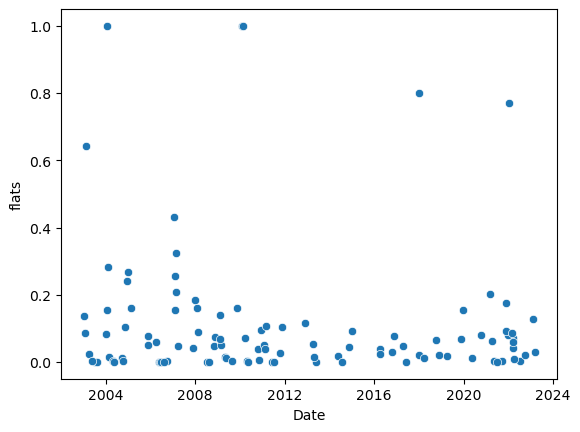

In [19]:
import seaborn as sns

dfy = df_combined[df_combined['Verified (m)'] < 0.18] #0.18 is lowest quartile - shown later

sns.scatterplot(data = dfy, x = 'Date', y = 'flats')

<Axes: xlabel='Verified (m)', ylabel='flats'>

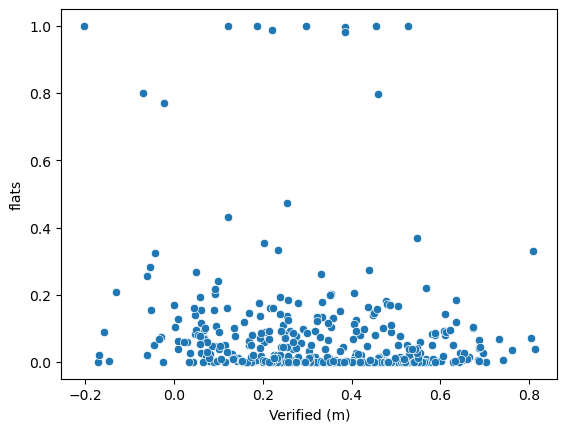

In [17]:
sns.scatterplot(data = df_combined, x = 'Verified (m)', y = 'flats') #This relationship needs to be much better

In [17]:
##Adding nutrient data

##CBMRR station
path = r'C:/Users/arj26323/Documents/Data/NERR data/Files 2024' #changed from Files folder 4/25/24
all_files = glob.glob(path + "/cbmrrnut*.csv")

li = []

for filename in all_files:
    df_sap = pd.read_csv(filename, index_col=None, header=0)
    li.append(df_sap)

df_sap = pd.concat(li, axis=0, ignore_index=True).dropna(subset=['NO23F']).dropna(axis=1)

##Begin:
df_sap = df_sap[df_sap['NO23F'] < 0.9] ##removes several extremely large outliers
df_sap['Date_m'] = pd.to_datetime(df_sap['DateTimeStamp'])
df_sap['DOY'] = df_sap['Date_m'].dt.strftime('%Y-%m-%d')
df_sap['DOY'] = pd.to_datetime(df_sap['DOY'])

df_sap

,StationCode,isSWMP,DateTimeStamp,Historical,ProvisionalPlus,CollMethd,REP,F_PO4F,NH4F,F_NH4F,F_NO2F,F_NO3F,NO23F,F_NO23F,F_CHLA_N,Date_m,DOY
4,cbmrrnut,P,04/29/2003 7:45,1,1,1,1,<4>,0.047,<4>,<4>,<4> C,0.871,<4>,<4>,2003-04-29 07:45:00,2003-04-29
5,cbmrrnut,P,05/06/2003 10:15,1,1,1,1,<4>,0.056,<4>,<4>,<4> C,0.834,<4>,<4>,2003-05-06 10:15:00,2003-05-06
7,cbmrrnut,P,05/20/2003 8:15,1,1,1,1,<4>,0.104,<4>,<4>,<4> C,0.761,<4>,<4>,2003-05-20 08:15:00,2003-05-20
8,cbmrrnut,P,05/28/2003 9:00,1,1,1,1,<4>,0.093,<4>,<4>,<4> C,0.559,<4>,<4>,2003-05-28 09:00:00,2003-05-28
10,cbmrrnut,P,06/10/2003 8:00,1,1,1,1,<4>,0.064,<4>,<4>,<4> C,0.798,<4>,<4>,2003-06-10 08:00:00,2003-06-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1129,cbmrrnut,P,10/19/2022 8:01,0,1,1,2,<1> (CHB),0.011,<1> (CHB),<1> (CHB),<1> (CHB),0.282,<1> (CHB),<0>,2022-10-19 08:01:00,2022-10-19
1130,cbmrrnut,P,11/17/2022 8:30,0,1,1,1,<1> (CHB),0.034,<1> (CHB),<1> (CHB),<1> (CHB),0.372,<0>,<0>,2022-11-17 08:30:00,2022-11-17
1131,cbmrrnut,P,11/17/2022 8:31,0,1,1,2,<1> (CHB),0.032,<1> (CHB),<1> (CHB),<1> (CHB),0.389,<0>,<0>,2022-11-17 08:31:00,2022-11-17
1132,cbmrrnut,P,12/06/2022 8:30,0,1,1,1,<1> (CHB),0.063,<1> (CHB),<1> (CHB),<1> (CHB),0.573,<1> (CHB),<0>,2022-12-06 08:30:00,2022-12-06


<Axes: xlabel='Date_m', ylabel='NO23F'>

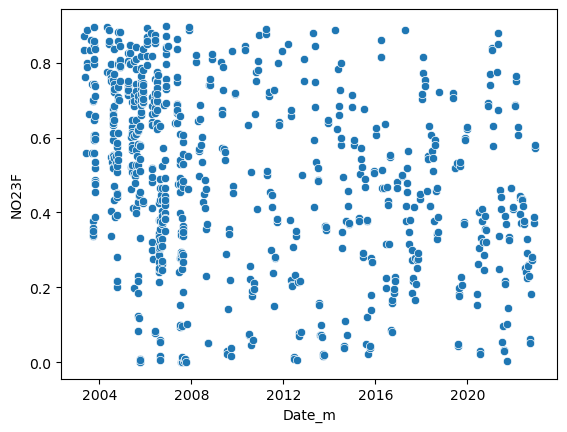

In [18]:
sns.scatterplot(data = df_sap, x = 'Date_m', y = 'NO23F')

In [19]:
##Merge, to nearest Landsat acquisition
df_combined2 = pd.merge_asof(
    df_combined.sort_values('Date'), 
    df_sap.sort_values('Date_m'), 
    left_on = 'Date',
    right_on = 'Date_m', 
    direction = 'nearest', 
    tolerance=pd.Timedelta("1210000000ms") ##Two weeks - is this ok?
)

df_combined2

,Shape_Area,Shape_Leng,acquisition_date,QA_PIXEL,QA_RADSAT,SR_ATMOS_OPACITY,SR_B1,SR_B2,SR_B3,SR_B4,...,F_PO4F,NH4F,F_NH4F,F_NO2F,F_NO3F,NO23F,F_NO23F,F_CHLA_N,Date_m,DOY_y
0,9236.88081,525.079752,1073489113391,5611.416216,0.0,11.0,0.072251,0.095576,0.108115,0.155777,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT
1,9236.88081,525.079752,1074180923309,5452.976589,0.0,84.0,0.068232,0.084077,0.101539,0.133205,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT
2,9236.88081,525.079752,1074871516564,6158.130841,0.0,12.0,0.099445,0.122944,0.141187,0.180025,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT
3,9236.88081,525.079752,1075563331796,13600.000000,0.0,NaN,0.507234,0.545063,0.572454,0.520572,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT
4,9236.88081,525.079752,1076253919691,6294.587514,0.0,8.0,0.092811,0.120080,0.139872,0.169456,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
530,9236.88081,525.079752,1699717595821,21837.895077,0.0,NaN,0.014074,0.023563,0.040401,0.054024,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT
531,9236.88081,525.079752,1700408801132,21847.923401,0.0,NaN,0.023393,0.031866,0.045748,0.057205,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT
532,9236.88081,525.079752,1701100001320,21845.815396,0.0,NaN,0.029253,0.033666,0.046028,0.060513,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT
533,9236.88081,525.079752,1702482397454,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT


In [22]:
len(df_combined2['NO23F'].dropna())

397

<Axes: xlabel='NO23F', ylabel='flats'>

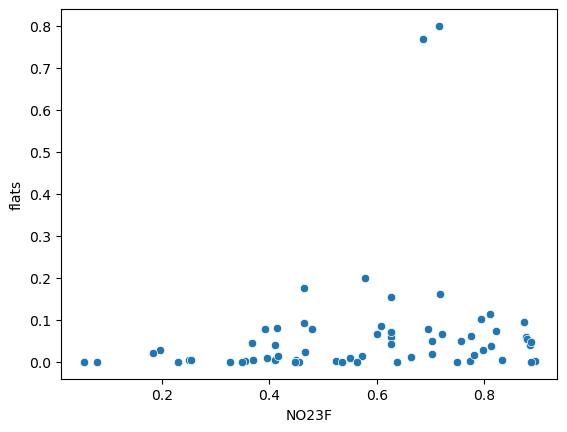

In [28]:
import seaborn as sns
import matplotlib as plt

dfz = df_combined2[df_combined2['Verified (m)'] < 0.18] ##Lowest quartile is 0.18 for tide

sns.scatterplot(data = dfz, x = 'NO23F', y = 'flats') ##This doesn't really tell you much. Need time + flats + N

In [24]:
print(dfz.shape)

##Tide quantiles will be different

max(dfz['Verified (m)'])

# dfz.quantile([.25, .5, 0.75])

df_combined['Verified (m)'].quantile([0,.25, .5, 0.75, 1])

(240, 51)


0.00   -0.28100
0.25    0.17925
0.50    0.32150
0.75    0.43775
1.00    0.84900
Name: Verified (m), dtype: float64

0.19058387053147804
Time lagged correlation coefficient between 'NO23F' and 'flats' (lag = 0): 0.19


<Axes: xlabel='NO23F', ylabel='flats'>

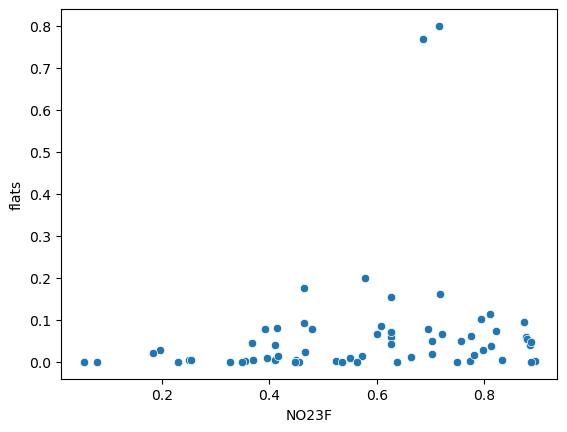

In [29]:
correlation = dfz['flats'].corr(dfz['NO23F'])
print(correlation)


##Time lag
lag = 0 #why choose this number?

no23_shifted = dfz['NO23F'].shift(-lag)

no23_shifted = no23_shifted.dropna()

# Calculate the correlation between the shifted variable and the original variable
time_lagged_corr = dfz['flats'].corr(no23_shifted)

# Print the time lagged correlation coefficient
print("Time lagged correlation coefficient between 'NO23F' and 'flats' (lag = {}): {:.2f}".format(lag, time_lagged_corr))

sns.scatterplot(x = no23_shifted, y = dfz['flats']) ##This doesn't really tell you much. Need time + flats + N

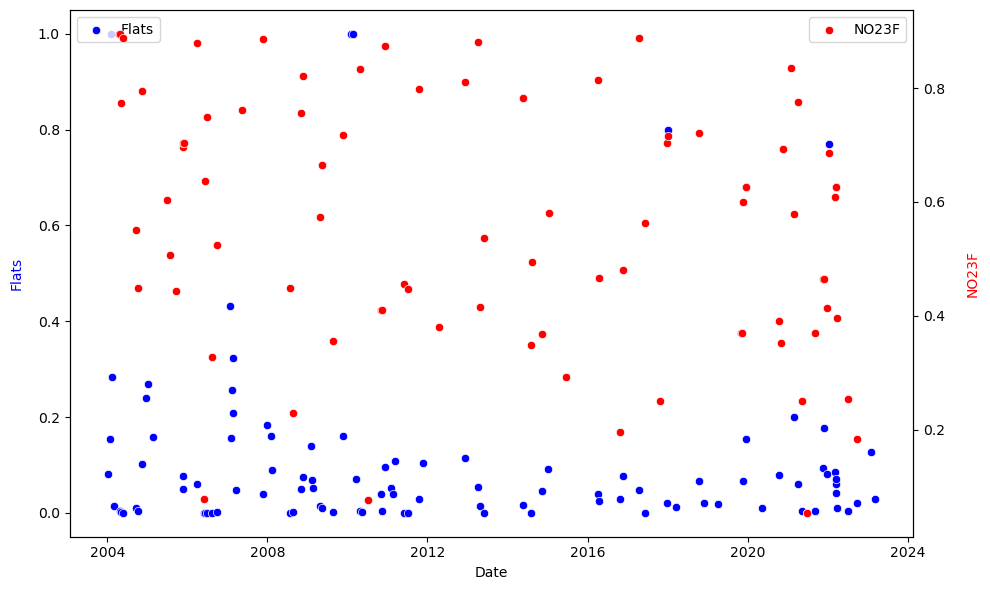

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(10, 6))

# Primary y-axis (flats)
sns.scatterplot(ax=ax1, data=dfz, x='Date', y='flats', label='Flats', color='blue')
ax1.set_ylabel('Flats', color='blue', labelpad=10)

# Secondary y-axis (NO23F)
ax2 = ax1.twinx()  # Create a twin axis that shares the x-axis
sns.scatterplot(ax=ax2, data=dfz, x='Date', y='NO23F', label='NO23F', color='red')
ax2.set_ylabel('NO23F', color='red',  labelpad=15)

# Customize the plot further (optional)
# Place legend on primary y-axis
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles, labels, loc='upper left')  

# Alternatively, place legend on secondary y-axis
handles2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(handles2, labels2, loc='upper right')


plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend()
plt.tight_layout()

# Display the plot
plt.show()